# Подготовительный этап

### Подключение библиотек

In [ ]:
%%capture

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import copy
from time import time

# вспомогательные функции
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# аугментация данных
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

Установим optuna

In [ ]:
%%capture
! pip install optuna
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

Установим CatBoostClassifier

In [ ]:
%%capture
! pip install catboost
from catboost import CatBoostClassifier

### Загрузка датасета

In [ ]:
df = pd.read_csv('hmeq.csv')

Рассмотрим данные таблицы:

In [ ]:
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


Для начала давайте рассмотрим длю пропусков в каждой колонке:

In [ ]:
df.isna().mean(axis=0)

BAD        0.000000
LOAN       0.000000
MORTDUE    0.086913
VALUE      0.018792
REASON     0.042282
JOB        0.046812
YOJ        0.086409
DEROG      0.118792
DELINQ     0.097315
CLAGE      0.051678
NINQ       0.085570
CLNO       0.037248
DEBTINC    0.212584
dtype: float64

# Работа с данными

При рассмотрении этих данных стоит учитывать тот факт, что все эти заявки - кредиты, уже одобренные прошлым алгоритмом. Из-за этого отличия в данных говорят скорее не об особенностях клиентов, а о предвзятостях существующей модели.

### Графики распределения по признакам

**Числовые признаки**

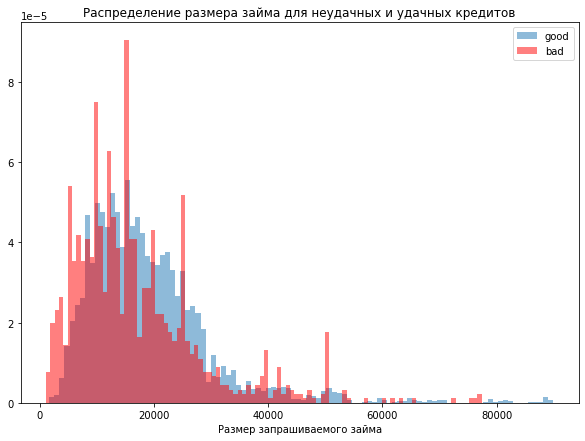

In [ ]:
plt.figure(figsize=(10, 7))
plt.hist(df['LOAN'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['LOAN'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Размер запрашиваемого займа')
plt.title('Распределение размера займа для неудачных и удачных кредитов')
plt.show()

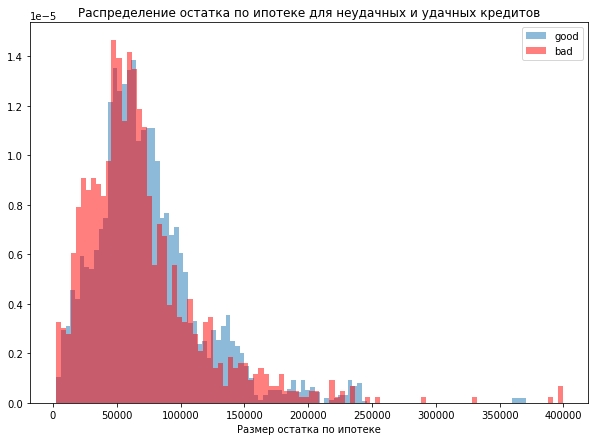

In [ ]:
plt.figure(figsize=(10, 7))

plt.hist(df['MORTDUE'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['MORTDUE'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Размер остатка по ипотеке')
plt.title('Распределение остатка по ипотеке для неудачных и удачных кредитов')

plt.show()

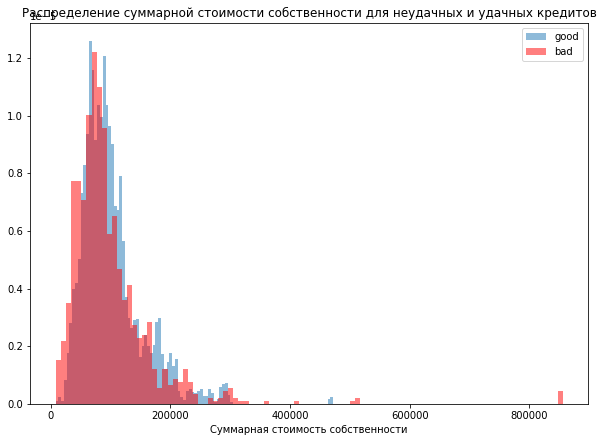

In [ ]:
plt.figure(figsize=(10, 7))

plt.hist(df['VALUE'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['VALUE'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Суммарная стоимость собственности')
plt.title('Распределение суммарной стоимости собственности для неудачных и удачных кредитов')

plt.show()

**Категориальные признаки**

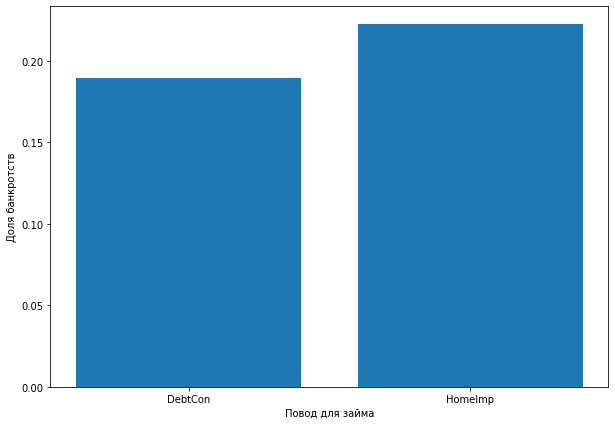

In [ ]:
plt.figure(figsize=(10, 7))
plt.bar(x=['DebtCon', 'HomeImp'], height=(df.groupby('REASON').mean()['BAD']))
plt.ylabel('Доля банкротств')
plt.xlabel('Повод для займа')
plt.show()

Интуитивно понятно, что реструктуризация долгов - потенциально более рискованная инвестиция, чем покупка для улучшения дома. Возможно прошлые данные овер-компенсировали этот риск, поэтому в нашем датасете реструктуризация статистически надежнее.

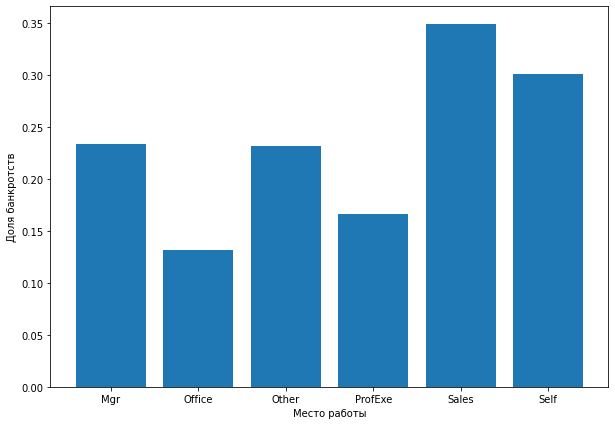

In [ ]:
plt.figure(figsize=(10, 7))
plt.bar(x=(df.groupby('JOB').mean()['BAD']).index, height=(df.groupby('JOB').mean()['BAD']))
plt.ylabel('Доля банкротств')
plt.xlabel('Место работы')

plt.show()

### Значимость признаков

Давайте оценим важность признаков с помощью t-статистики, чтобы выделить наиболее значимые для нашей классификации

In [ ]:
dfpos = df[df['BAD'] == 0].drop(['BAD', 'JOB', 'REASON'] , axis=1)
dfneg = df[df['BAD'] == 1].drop(['BAD', 'JOB', 'REASON'] , axis=1)
t = np.abs(dfpos.mean(axis=0) - dfneg.mean(axis=0)) / np.sqrt((len(dfpos) * dfpos.std(axis=0)**2 + len(dfneg) * dfneg.std(axis=0)**2)/ (len(dfpos) + len(dfneg)))


In [ ]:
t

LOAN       0.188425
MORTDUE    0.120885
VALUE      0.076650
YOJ        0.148999
DEROG      0.715846
DELINQ     0.944193
CLAGE      0.435324
NINQ       0.441615
CLNO       0.010427
DEBTINC    0.609487
dtype: float64

'DEROG', 'DELINQ' - обобщая, эти признаки говорят нам об уже просроченных кредитах. Понятно, почему эти признаки очень важны.

'DEBTINC' - отношение долга к доходу

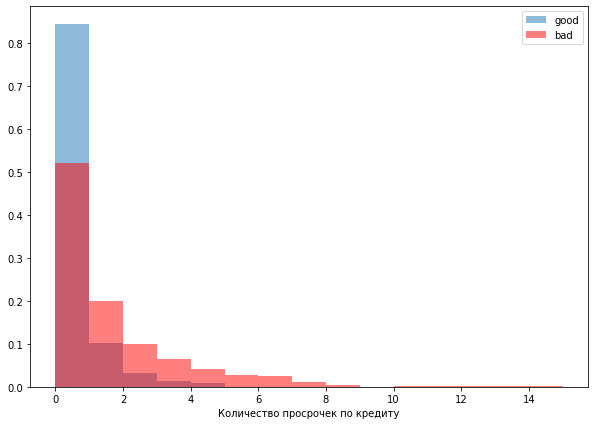

In [ ]:
plt.figure(figsize=(10, 7))

plt.hist(df['DELINQ'][df['BAD'] == 0], bins=5, alpha=0.5, label='good', density=True)
plt.hist(df['DELINQ'][df['BAD'] == 1], bins=15, alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Количество просрочек по кредиту')

plt.show()

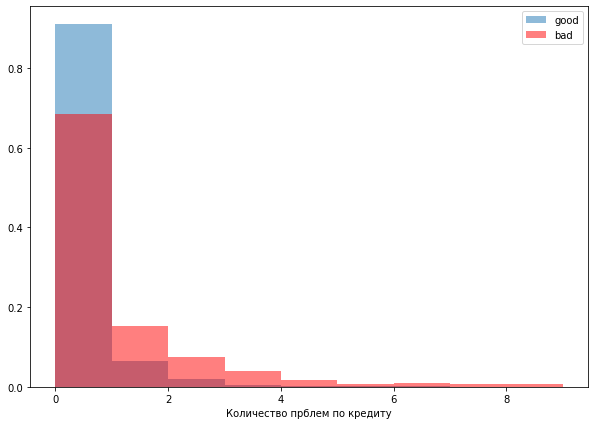

In [ ]:
plt.figure(figsize=(10, 7))

plt.hist(df['DEROG'][df['BAD'] == 0], bins=range(10), alpha=0.5, label='good', density=True)
plt.hist(df['DEROG'][df['BAD'] == 1], bins=range(10), alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Количество прблем по кредиту')

plt.show()

In [ ]:
df['REASON'].value_counts()

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64

In [ ]:
df['JOB'].value_counts()

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64

In [ ]:
df.isna().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

### Заполнение пропусков

Давайте для начала заполним пропуски в категориальных переменных отдельным значением, в числовых - средним, а переменную с наибольшим количеством пропусков пока удалим.

In [ ]:
df_pure = copy.deepcopy(df).drop('DEBTINC', axis=1)
df_pure[['JOB', 'REASON']] = df_pure[['JOB', 'REASON']].fillna('NAN')
df_pure = df_pure.fillna(df_pure.mean(axis=0))

y = df_pure['BAD'].values
X = df_pure.drop("BAD", axis=1).values

Закодируем категориальные переменные

In [ ]:
ohe = OneHotEncoder(sparse=False)

In [ ]:
X = np.concatenate((X[:, :3], ohe.fit_transform(X[:, [3, 4]]), X[:, 5:]), axis=1)

Разобьем на тренировочные и тестовые данные

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=179)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=179)

Проверим данные

In [ ]:
isnatrain, isnatest = train_test_split(df.isna().mean(axis=1), test_size=0.3, random_state=179)

# Вспомогательные функции

Рассмотрим различные критерии, по которым можно сравнить результат работы моделей

### Стандартные критерии



*   accuracy, как удобныая и интерпретируемая, но не всегда информативная метрика
*   площадь под precision-recall кривой
*   площадь по tpr/fpr кривой
*   F-мера



### Вспомогательные критерии 

Реализуем также 

*   Cohen's kappa coefficient (https://en.wikipedia.org/wiki/Cohen%27s_kappa) 

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

*   Matthews correlation coefficient (https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 



In [ ]:
def kappa(y0, y1, pos=1, neg=0):
    po = accuracy_score(y0, y1)

    pos0 = (y0 == pos).mean()
    pos1 = (y1 == pos).mean()
    pe = (pos0 * pos1) + (1 - pos0) * (1 - pos1)

    k = (po - pe) / (1 - pe)
    return k

def matthews(pred, target, pos=1, neg=0):
    tp = np.sum((pred == pos) & (target == pos))
    tn = np.sum((pred == neg) & (target == neg))
    fp = np.sum((pred == pos) & (target == neg))
    fn = np.sum((pred == neg) & (target == pos))

    if (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) == 0:
        return 0 # условность, чтобы не вылезало так много nan

    return (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

### Бизнес критерий

Было бы логично предположить, что невозврат денег для нас несет больше урона, чем бы нам принесло успешное возвращение. Это говорит нам о том, что порог выдачи кредита стоит выставить ниже чем 0.5 вероятности дефолта

Напишем функцию, которая максимизирует ожидание прибыли, исходя из предположения о том, что наша выгода составляет x% суммы, и если человек не возвращает сумму, он не возвращает ее целиком

In [ ]:
def get_prediction(mod, X_test, y_test, x=15):
    y_prob = mod.predict_proba(X_test)[:, 1]
    threshold = (x / 100) / (1 + x / 100)
    y_pred = y_prob > threshold
    return y_pred * 1.0

Введем метрику, которая оценивает лосс как упущенную выгоду, по сравнению с идеальным предсказанием.

In [ ]:
def get_gain(y_pred, y_target, loan, x=15):
    return (((y_pred == 1) & (y_target == 1)) * loan - ((y_pred == 1) & (y_target == 0)) * loan * x / 100).sum() / loan.sum()

### Объеденим в функцию

In [ ]:
logs = dict()

In [ ]:
def rate(mod, X_test, y_test, name="model", x=15):
    y_pred = mod.predict(X_test)
    print("====== " + name + " ======")
    print()
    ac = accuracy_score(y_pred, y_test)
    print(f"Accuracy:\t{accuracy_score(y_pred, y_test)}")
    print(f"Pos/neg ratio:\t{(y_pred == 1).sum() / (y_pred == 0).sum()}")
    print()

    print(f"Kappa coef:\t{kappa(y_pred, y_test)}")
    print(f"Matthews coef:\t{matthews(y_pred, y_test)}")
    print(f"ROC-AUC value:\t{roc_auc_score(y_test, mod.predict_proba(X_test)[:, 1])}")
    auc_pr = auc(*reversed((precision_recall_curve(y_test, mod.predict_proba(X_test)[:, 1]))[:2]))
    print(f"PR-AUC value:\t{auc_pr}")
    pr = precision_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    print()
    print(f"Precision:\t{pr}")
    print(f"Recall: \t{rc}")
    fscore = 2 * pr * rc / (pr + rc)
    print(f"F-score:\t{fscore}")

    loan = X_test[:, 0]
    y_pred_financial = get_prediction(mod, X_test, y_test, x=x)
    gains = get_gain(y_pred_financial, y_test, loan, x=x)
    print(f"Financial gain:\t{gains}")
    print()
    print("=======" + '=' * len(name) + "=======")
    return ac, auc_pr, fscore, gains

In [ ]:
def string_time(elapsed):
    return "%im %is" %(int(elapsed / 60), int(elapsed % 60))

In [ ]:
def run(mod, X_train, y_train, X_test, y_test, name='model', x=15):
    global logs

    start_time = time()
    mod.fit(X_train, y_train)
    end_time = time()
    ac, auc_pr, fscore, gains = rate(mod, X_test, y_test, name=name, x=x)
    elapsed = end_time - start_time
    print("Time elapsed: " + string_time(elapsed))

    logs[name] = [ac, auc_pr, fscore, gains, elapsed, name]

    return mod.predict(X_test)

### Калибровочная кривая

Для оценки результата и внесения корректировок нам также понадобится калибровочная кривая

In [ ]:
def calibration_curve(mod, X, y):
    probs = mod.predict_proba(X)[:, 1]
    vals = []
    for prob in np.arange(0, 1, 0.05):
        vals.append(y[(probs >= prob) & (probs < prob + 0.05)].mean())
    plt.plot(np.arange(0, 1, 0.05) + 0.025, vals, label='Our curve')
    plt.plot(np.arange(0, 1, 0.05) + 0.025, np.arange(0, 1, 0.05) + 0.025, label='Perfect curve')
    return vals

def build_calibration_curve(mod, X, y, sz=(10,10)):
    plt.figure(figsize=sz)
    vals = calibration_curve(mod, X, y)
    plt.xlabel('Predicted probability', fontdict={'size':15})
    plt.ylabel('Fraction of positive results for this probability', fontdict={'size':15})
    plt.legend()
    plt.show()

### Разное

In [ ]:
def print_vals(d):
    ans = ''
    for key, val in d.items():
        ans += key + '=' + str(val) + ', '
    return ans[:-2]

# Подготовка базовой модели

Перед сравнением моделей выведем баланс классов в исходной выборке

In [ ]:
print(f"Positive train targets: {(y_train == 1).sum()}, negative train targets: {(y_train == 0).sum()}, ratio: {(y_train == 1).sum() / (y_train == 0).sum()}")
print(f"Positive val targets: {(y_val == 1).sum()}, negative val targets: {(y_val == 0).sum()}, ratio: {(y_val == 1).sum() / (y_val == 0).sum()}")
print(f"Positive test targets: {(y_test == 1).sum()}, negative test targets: {(y_test == 0).sum()}, ratio: {(y_test == 1).sum() / (y_test == 0).sum()}")

Positive train targets: 994, negative train targets: 4072, ratio: 0.24410609037328093
Positive val targets: 96, negative val targets: 351, ratio: 0.27350427350427353
Positive test targets: 99, negative test targets: 348, ratio: 0.28448275862068967


В качестве baseline будем использовать random forest

In [ ]:
rlf_baseline = RandomForestClassifier(n_estimators=1000, random_state=179)
y_pred = run(rlf_baseline, X_train, y_train, X_test, y_test, name='Random Forest', x=15)

====== Random Forest ======

Accuracy:	0.9463087248322147
Pos/neg ratio:	0.20810810810810812

Kappa coef:	0.8308580077570711
Matthews coef:	0.8410284623553973
ROC-AUC value:	0.9902618135376756
PR-AUC value:	0.9752986314553959

Precision:	0.987012987012987
Recall: 	0.7676767676767676
F-score:	0.8636363636363635
Financial gain:	0.2009025651852634

Time elapsed: 0m 6s


Заметим, что если выдавать кредит согласно предсказаниям модели, без поправки на оценку прибыли, ожидаемая прибыль будет существенно хуже:

In [ ]:
get_gain(y_pred, y_test, X_test[:, 0])

0.1689122300808145

И рассмотрим как значение критерия зависит от параметра $x$

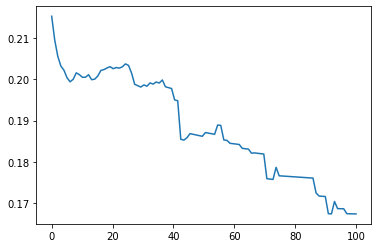

In [ ]:
x_s = np.linspace(0, 100, num=100)
y_s = [get_gain(get_prediction(rlf_baseline, X_test, y_test, x=cur), y_test, X_test[:, 0], x=cur) for cur in x_s]

plt.plot(x_s, y_s)

Также сравним со **случайным классификатором**

In [ ]:
random_dummy = DummyClassifier(strategy="uniform")
y_pred = run(random_dummy, X_train, y_train, X_test, y_test, name='Random Forest', x=15)

====== Random Forest ======

Accuracy:	0.5458612975391499
Pos/neg ratio:	0.8244897959183674

Kappa coef:	0.040295713424501126
Matthews coef:	0.04613484159966726
ROC-AUC value:	0.5
PR-AUC value:	0.610738255033557

Precision:	0.24257425742574257
Recall: 	0.494949494949495
F-score:	0.3255813953488372
Financial gain:	0.09752982159822654

Time elapsed: 0m 0s


И **константным классификатором**

In [ ]:
constant_dummy = DummyClassifier(strategy="most_frequent")
y_pred = run(constant_dummy, X_train, y_train, X_test, y_test, name='Random Forest', x=15)

====== Random Forest ======

Accuracy:	0.7785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.5
PR-AUC value:	0.610738255033557

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0

Time elapsed: 0m 0s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning:

invalid value encountered in double_scalars



# Стандартные методы классификации

###Логистическая регрессия 

In [ ]:
def objective(trial: Trial, X_train, y_train, X_val, y_val, financial=False, verbose=False) -> float:
    
    param = {
                'C':trial.suggest_loguniform('C', 0.1, 10),
                'solver':trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
            }

    mod = LogisticRegression(**param, random_state=179, max_iter=1000)
    mod.fit(X_train, y_train)

    if not financial:
        auc_pr = auc(*reversed((precision_recall_curve(y_val, mod.predict_proba(X_val)[:, 1]))[:2]))
        res = auc_pr
    else:
        loan = X_val[:, 0]
        y_pred_financial = get_prediction(mod, X_val, y_val)
        gains = get_gain(y_pred_financial, y_val, loan, x=15)
        res = gains

    if verbose:
        print("Trial:", print_vals(param), end=';\t')
        print('Result', res, end=';\t')
        print("Time elapsed: " + string_time(time() - start))

    return res

In [ ]:
%%time
study_logreg = optuna.create_study(direction='maximize', sampler=TPESampler())
study_logreg.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=False), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_logreg.best_trial.value, study_logreg.best_trial.params))

Best trial: score 0.5591326948459276,
params {'C': 0.13851857591564923, 'solver': 'liblinear'}
CPU times: user 4.26 s, sys: 2.18 s, total: 6.44 s
Wall time: 3.92 s


In [ ]:
logreg = LogisticRegression(**study_logreg.best_trial.params, random_state=179, max_iter=1000)
y_pred = run(logreg, X_train, y_train, X_test, y_test, name='LogReg', x=15)

====== LogReg ======

Accuracy:	0.8210290827740492
Pos/neg ratio:	0.09024390243902439

Kappa coef:	0.33116373022107515
Matthews coef:	0.38724913340145206
ROC-AUC value:	0.7610298386160455
PR-AUC value:	0.566865592047224

Precision:	0.7567567567567568
Recall: 	0.2828282828282828
F-score:	0.4117647058823529
Financial gain:	0.10221858615714839

Time elapsed: 0m 0s


In [ ]:
%%time
study_logreg_f = optuna.create_study(direction='maximize', sampler=TPESampler())
study_logreg_f.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=True), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_logreg_f.best_trial.value, study_logreg_f.best_trial.params))

Best trial: score 0.07324742204231192,
params {'C': 0.14648123713571498, 'solver': 'lbfgs'}
CPU times: user 7.4 s, sys: 5.45 s, total: 12.8 s
Wall time: 6.58 s


In [ ]:
logreg_f = LogisticRegression(**study_logreg_f.best_trial.params, random_state=179, max_iter=1000)
y_pred = run(logreg_f, X_train, y_train, X_test, y_test, name='LogReg G', x=15)

====== LogReg G ======

Accuracy:	0.7807606263982103
Pos/neg ratio:	0.002242152466367713

Kappa coef:	0.015639746528246255
Matthews coef:	0.08877784430449509
ROC-AUC value:	0.6342737722048066
PR-AUC value:	0.37568536295799004

Precision:	1.0
Recall: 	0.010101010101010102
F-score:	0.02
Financial gain:	0.07477685116764606

Time elapsed: 0m 0s


### Градиентный бустинг (catboost)

In [ ]:
def objective(trial: Trial, X_train, y_train, X_val, y_val, financial=False, verbose=False) -> float:
    
    param = {
        'iterations' : trial.suggest_int('iterations', 50, 300),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        #'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    }

    mod = CatBoostClassifier(**param, random_state=179, task_type="GPU")
    mod.fit(X_train, y_train,
            eval_set=((X_val, y_val)),
            early_stopping_rounds=100,
            logging_level='Silent',
        )

    if not financial:
        auc_pr = auc(*reversed((precision_recall_curve(y_val, mod.predict_proba(X_val)[:, 1]))[:2]))
        res = auc_pr
    else:
        loan = X_val[:, 0]
        y_pred_financial = get_prediction(mod, X_val, y_val)
        gains = get_gain(y_pred_financial, y_val, loan, x=15)
        res = gains

    if verbose:
        print("Trial:", print_vals(param), end=';\t')
        print('Result', res, end=';\t')
        print("Time elapsed: " + string_time(time() - start))

    return res

In [ ]:
%%time
start = time()
study_catboost = optuna.create_study(direction='maximize', sampler=TPESampler())
study_catboost.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=False), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_catboost.best_trial.value, study_catboost.best_trial.params))

Best trial: score 0.957946692058554,
params {'iterations': 287, 'depth': 10, 'random_strength': 12, 'bagging_temperature': 5.859314223946918, 'learning_rate': 0.08103220429213837, 'od_type': 'IncToDec'}
CPU times: user 6min 10s, sys: 3min 44s, total: 9min 55s
Wall time: 5min 56s


In [ ]:
catboost = CatBoostClassifier(**study_catboost.best_trial.params, random_state=179, task_type="GPU")
y_pred = run(catboost, X_train, y_train, X_test, y_test, name='Catboost', x=15)

====== Catboost ======

Accuracy:	0.9530201342281879
Pos/neg ratio:	0.21798365122615804

Kappa coef:	0.8537235285867887
Matthews coef:	0.8612998123681417
ROC-AUC value:	0.9860965981655637
PR-AUC value:	0.975230171524463

Precision:	0.9875
Recall: 	0.797979797979798
F-score:	0.88268156424581
Financial gain:	0.19259767526420118

Time elapsed: 0m 5s


Этот бустинг показал себя лучше всех (в сравнении с двумя следующими), поэтому попробуем прооптимизировать именно его по другой метрике:

In [ ]:
%%time
study_catboost_f = optuna.create_study(direction='maximize', sampler=TPESampler())
study_catboost_f.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=True), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_catboost_f.best_trial.value, study_catboost_f.best_trial.params))

Best trial: score 0.1755171389311843,
params {'iterations': 289, 'depth': 9, 'random_strength': 9, 'bagging_temperature': 0.8214215254433717, 'learning_rate': 0.0688597515877417, 'od_type': 'IncToDec'}
CPU times: user 5min 21s, sys: 3min 15s, total: 8min 37s
Wall time: 5min 16s


In [ ]:
catboost_f = CatBoostClassifier(**study_catboost_f.best_trial.params, random_state=179, task_type="GPU")
y_pred = run(catboost_f, X_train, y_train, X_test, y_test, name='Catboost G', x=15)

====== Catboost G ======

Accuracy:	0.9574944071588367
Pos/neg ratio:	0.22465753424657534

Kappa coef:	0.8686737486663265
Matthews coef:	0.8747333816253727
ROC-AUC value:	0.9911180773249739
PR-AUC value:	0.9778273432788465

Precision:	0.9878048780487805
Recall: 	0.8181818181818182
F-score:	0.8950276243093922
Financial gain:	0.19504791395427942

Time elapsed: 0m 3s


### Градиентный бустинг (xgboost)

In [ ]:
def objective(trial: Trial, X_train, y_train, X_val, y_val, financial=False, verbose=False) -> float:
    
    param = {
        "silent": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "seed": 179,
        "predictor":"gpu_predictor",
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    mod = XGBClassifier(**param)
    mod.fit(X_train, y_train,
            #eval_set=((X_val, y_val)),
            #early_stopping_rounds=100,
        )

    if not financial:
        auc_pr = auc(*reversed((precision_recall_curve(y_val, mod.predict_proba(X_val)[:, 1]))[:2]))
        res = auc_pr
    else:
        loan = X_val[:, 0]
        y_pred_financial = get_prediction(mod, X_val, y_val)
        gains = get_gain(y_pred_financial, y_val, loan, x=15)
        res = gains

    if verbose:
        print("Trial:", print_vals(param), end=';\t')
        print('Result', res, end=';\t')
        print("Time elapsed: " + string_time(time() - start))

    return res

In [ ]:
%%time
start = time()
study_xgboost = optuna.create_study(direction='maximize', sampler=TPESampler())
study_xgboost.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=False), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_xgboost.best_trial.value, study_xgboost.best_trial.params))

Best trial: score 0.8966179130972544,
params {'booster': 'dart', 'lambda': 6.520903437932355e-08, 'alpha': 2.5753706202031648e-06, 'max_depth': 9, 'eta': 1.0910605622881362e-08, 'gamma': 6.51697015656391e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.002173287066760583, 'skip_drop': 1.1198428075289088e-06}
CPU times: user 1min 41s, sys: 39.3 ms, total: 1min 41s
Wall time: 1min 40s


In [ ]:
xgboost = XGBClassifier(**study_xgboost.best_trial.params)
y_pred = run(xgboost, X_train, y_train, X_test, y_test, name='XGBoost', x=15)

====== XGBoost ======

Accuracy:	0.9440715883668904
Pos/neg ratio:	0.22465753424657534

Kappa coef:	0.8272023008767455
Matthews coef:	0.8329726402405023
ROC-AUC value:	0.9716126785092302
PR-AUC value:	0.9501752367565631

Precision:	0.9512195121951219
Recall: 	0.7878787878787878
F-score:	0.861878453038674
Financial gain:	0.18662749099780662

Time elapsed: 0m 2s


### Градиентный бустинг (lightgbm)

In [ ]:
def objective(trial: Trial, X_train, y_train, X_val, y_val, financial=False, verbose=False) -> float:
    
    param = {
        "objective": "binary",
        "metric": "binary_error",
        "verbosity": -1,
        "boosting_type": "gbdt",                
        "seed": 179,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    }

    mod = LGBMClassifier(**param)
    mod.fit(X_train, y_train)

    if not financial:
        auc_pr = auc(*reversed((precision_recall_curve(y_val, mod.predict_proba(X_val)[:, 1]))[:2]))
        res = auc_pr
    else:
        loan = X_val[:, 0]
        y_pred_financial = get_prediction(mod, X_val, y_val)
        gains = get_gain(y_pred_financial, y_val, loan, x=15)
        res = gains

    if verbose:
        print("Trial:", print_vals(param), end=';\t')
        print('Result', res, end=';\t')
        print("Time elapsed: " + string_time(time() - start))

    return res

In [ ]:
%%time
start = time()
study_lightgbm = optuna.create_study(direction='maximize', sampler=TPESampler())
study_lightgbm.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=False, verbose=False), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_lightgbm.best_trial.value, study_lightgbm.best_trial.params))

Best trial: score 0.953655700821096,
params {'lambda_l1': 6.375953777388818e-05, 'lambda_l2': 7.270828729230591e-05, 'num_leaves': 179, 'feature_fraction': 0.44230882658826254, 'bagging_fraction': 0.7405713173067001, 'bagging_freq': 7, 'min_child_samples': 2}
CPU times: user 31.3 s, sys: 1.47 s, total: 32.8 s
Wall time: 32.6 s


In [ ]:
lightgbm = LGBMClassifier(**study_lightgbm.best_trial.params)
y_pred = run(lightgbm, X_train, y_train, X_test, y_test, name='LightGBM', x=15)

====== LightGBM ======

Accuracy:	0.9440715883668904
Pos/neg ratio:	0.19839142091152814

Kappa coef:	0.8217106207820802
Matthews coef:	0.8350903566741866
ROC-AUC value:	0.9805236270753512
PR-AUC value:	0.9632655925497828

Precision:	1.0
Recall: 	0.7474747474747475
F-score:	0.8554913294797689
Financial gain:	0.18414675627807686

Time elapsed: 0m 0s


### Случайный лес

In [ ]:
def objective(trial: Trial, X_train, y_train, X_val, y_val, financial=False, verbose=False) -> float:
    
    param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
        }

    mod = RandomForestClassifier(**param, random_state=179, n_jobs=-1)
    mod.fit(X_train, y_train)

    if not financial:
        auc_pr = auc(*reversed((precision_recall_curve(y_val, mod.predict_proba(X_val)[:, 1]))[:2]))
        res = auc_pr
    else:
        loan = X_val[:, 0]
        y_pred_financial = get_prediction(mod, X_val, y_val)
        gains = get_gain(y_pred_financial, y_val, loan, x=15)
        res = gains

    if verbose:
        print("Trial:", print_vals(param), end=';\t')
        print('Result', res, end=';\t')
        print("Time elapsed: " + string_time(time() - start))

    return res

In [ ]:
%%time
start = time()
study_forest = optuna.create_study(direction='maximize', sampler=TPESampler())
study_forest.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=False, verbose=False), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_forest.best_trial.value, study_forest.best_trial.params))

Best trial: score 0.9280802627542757,
params {'n_estimators': 914, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 1}
CPU times: user 11min 8s, sys: 17.7 s, total: 11min 25s
Wall time: 6min 35s


In [ ]:
forest = RandomForestClassifier(**study_forest.best_trial.params, random_state=179, n_jobs=-1)
y_pred = run(forest, X_train, y_train, X_test, y_test, name='Random Forest', x=15)

====== Random Forest ======

Accuracy:	0.9351230425055929
Pos/neg ratio:	0.192

Kappa coef:	0.7915279587012111
Matthews coef:	0.806872408809275
ROC-AUC value:	0.9831069313827935
PR-AUC value:	0.9603078432233794

Precision:	0.9861111111111112
Recall: 	0.7171717171717171
F-score:	0.8304093567251463
Financial gain:	0.1918170941975439

Time elapsed: 0m 4s


In [ ]:
%%time
study_forest_f = optuna.create_study(direction='maximize', sampler=TPESampler())
study_forest_f.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=True), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_forest_f.best_trial.value, study_forest_f.best_trial.params))

Best trial: score 0.17135960188658225,
params {'n_estimators': 54, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1}
CPU times: user 8min 28s, sys: 13.6 s, total: 8min 42s
Wall time: 5min 3s


In [ ]:
forest_f = RandomForestClassifier(**study_forest_f.best_trial.params, random_state=179, n_jobs=-1)
y_pred = run(forest_f, X_train, y_train, X_test, y_test, name='Random Forest G', x=15)

====== Random Forest G ======

Accuracy:	0.9395973154362416
Pos/neg ratio:	0.19839142091152814

Kappa coef:	0.8074474704446464
Matthews coef:	0.8205949625520461
ROC-AUC value:	0.9876204574480436
PR-AUC value:	0.9708241901233998

Precision:	0.9864864864864865
Recall: 	0.7373737373737373
F-score:	0.8439306358381503
Financial gain:	0.19907221694406324

Time elapsed: 0m 0s


# Аугментация данных

Давайте попробуем лучшие из рассмотренных моделей с использованием апсемплинга минорного класса. Так как отношение размеров классов уже близкое, стоит увеличивать его только до равенства классов.

### SMOTE

In [ ]:
X_train_aug, y_train_aug = SMOTE(random_state=179, n_jobs=-1).fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
forest_smote = RandomForestClassifier(**study_forest.best_trial.params, random_state=179, n_jobs=-1)
y_pred = run(forest_smote, X_train_aug, y_train_aug, X_test, y_test, name='Forest SMOTE', x=15)

====== Forest SMOTE ======

Accuracy:	0.9485458612975392
Pos/neg ratio:	0.22465753424657534

Kappa coef:	0.8410261168066058
Matthews coef:	0.8468928873687924
ROC-AUC value:	0.9893765238592824
PR-AUC value:	0.9634371870800584

Precision:	0.9634146341463414
Recall: 	0.797979797979798
F-score:	0.8729281767955802
Financial gain:	0.1894002838476606

Time elapsed: 0m 7s


### SVMSMOTE

In [ ]:
%%capture
X_train_aug, y_train_aug = SVMSMOTE(random_state=179, n_jobs=-1).fit_resample(X_train, y_train)

In [ ]:
forest_svmsmote = RandomForestClassifier(**study_forest.best_trial.params, random_state=179, n_jobs=-1)
y_pred = run(forest_svmsmote, X_train_aug, y_train_aug, X_test, y_test, name='Forest SVMSMOTE', x=15)

====== Forest SVMSMOTE ======

Accuracy:	0.9463087248322147
Pos/neg ratio:	0.21467391304347827

Kappa coef:	0.8321757086540266
Matthews coef:	0.8404353426826142
ROC-AUC value:	0.9788691512829445
PR-AUC value:	0.9561118101837778

Precision:	0.9746835443037974
Recall: 	0.7777777777777778
F-score:	0.8651685393258427
Financial gain:	0.18234807699074562

Time elapsed: 0m 7s


###ADASYN

In [ ]:
%%capture
X_train_aug, y_train_aug = ADASYN(random_state=179, n_jobs=-1).fit_resample(X_train, y_train)

In [ ]:
forest_adasyn = RandomForestClassifier(**study_forest.best_trial.params, random_state=179, n_jobs=-1)
y_pred = run(forest_adasyn, X_train_aug, y_train_aug, X_test, y_test, name='Forest ADASYN', x=15)

====== Forest ADASYN ======

Accuracy:	0.9552572706935123
Pos/neg ratio:	0.23480662983425415

Kappa coef:	0.8633403650371457
Matthews coef:	0.8673179727189516
ROC-AUC value:	0.990073145245559
PR-AUC value:	0.9644571354232693

Precision:	0.9647058823529412
Recall: 	0.8282828282828283
F-score:	0.8913043478260869
Financial gain:	0.190552681891223

Time elapsed: 0m 7s


# Сравнение моделей

In [ ]:
names = list(logs.keys())
names

['Random Forest',
 'LogReg',
 'LogReg G',
 'Catboost',
 'Catboost G',
 'XGBoost',
 'LightGBM',
 'Random Forest G',
 'Forest SMOTE',
 'Forest SVMSMOTE',
 'Forest ADASYN']

In [ ]:
# [ac, auc_pr, fscore, gains, elapsed, name]
names = list(logs.keys())

log_data = pd.DataFrame()
log_data['model'] = names
log_data['accuracy'] = [logs[nm][0] for nm in names]
log_data['auc_pr'] = [logs[nm][1] for nm in names]
log_data['fscore'] = [logs[nm][2] for nm in names]
log_data['gains'] = [logs[nm][3] for nm in names]
log_data['time'] = [logs[nm][4] for nm in names]

colors = np.array(sns.color_palette("hls", len(names)))

In [ ]:
def build_analysis(feat):
    plt.figure(figsize=(24, 7))
    splot = sns.barplot(x='model', y=feat, data=log_data.sort_values([feat], ascending=False), palette=colors[np.argsort(log_data[feat])[::-1]])

    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.3f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

    plt.show()

**Accuracy**

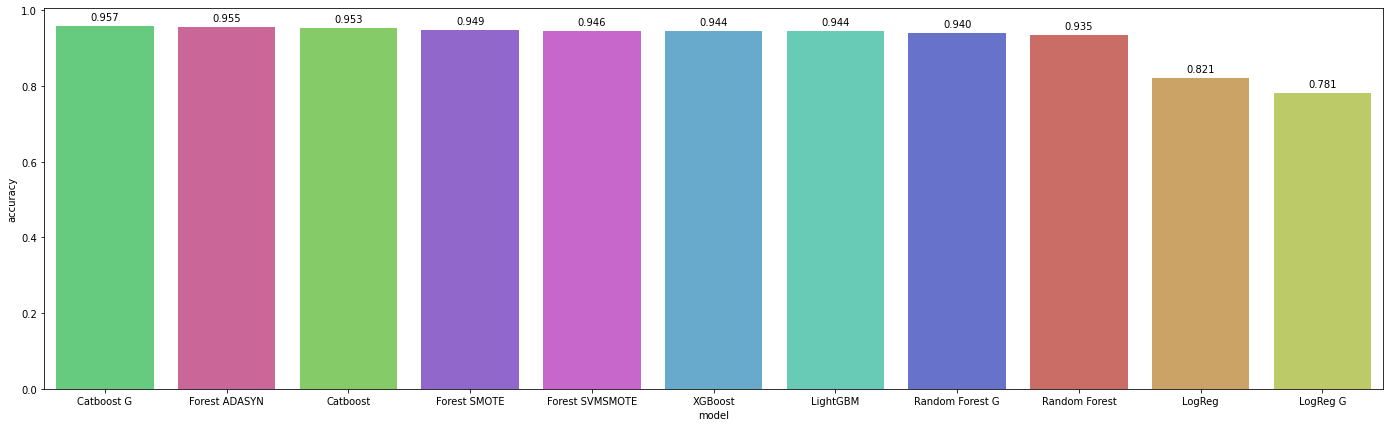

In [ ]:
build_analysis('accuracy')

**PR AUC**

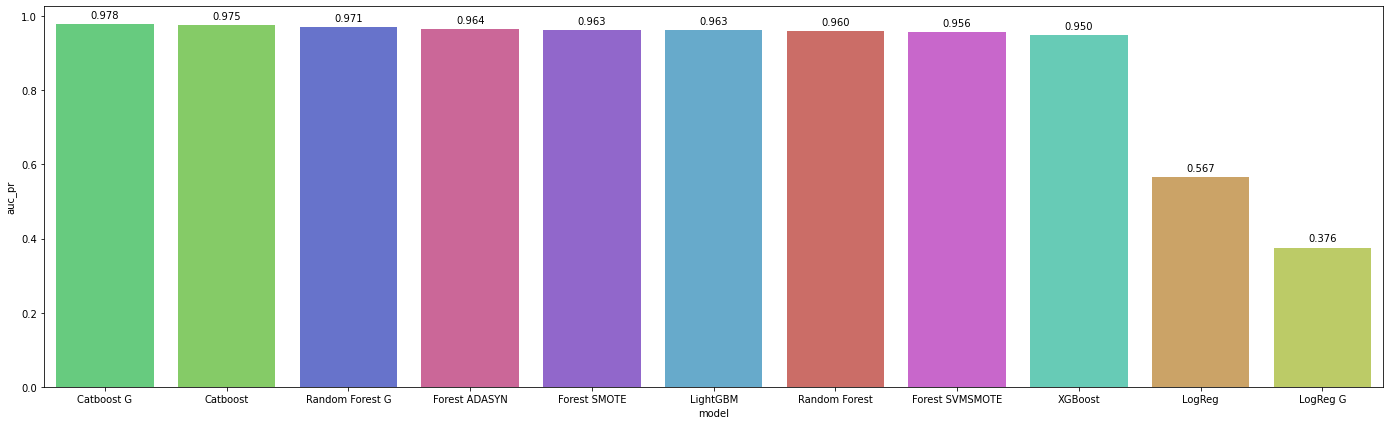

In [ ]:
build_analysis('auc_pr')

**F-мера**

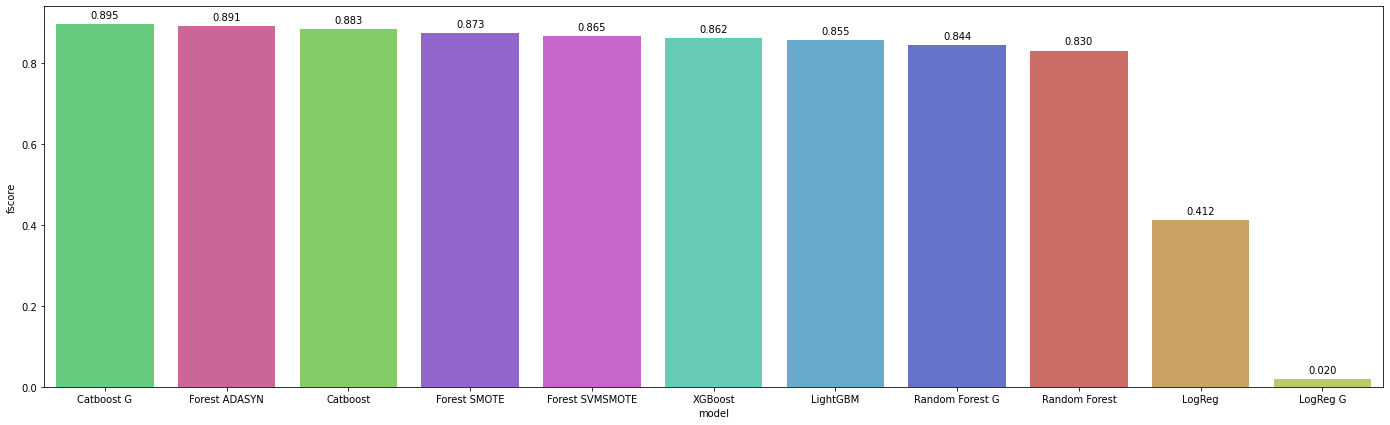

In [ ]:
build_analysis('fscore')

**Финансовая выгода**

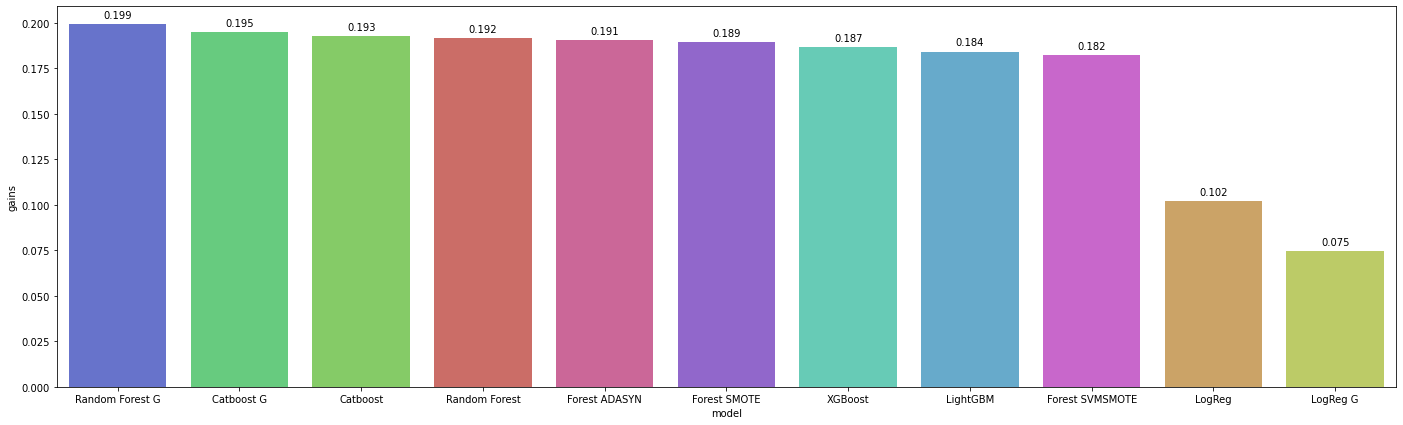

In [ ]:
build_analysis('gains')

**Затраченное время**

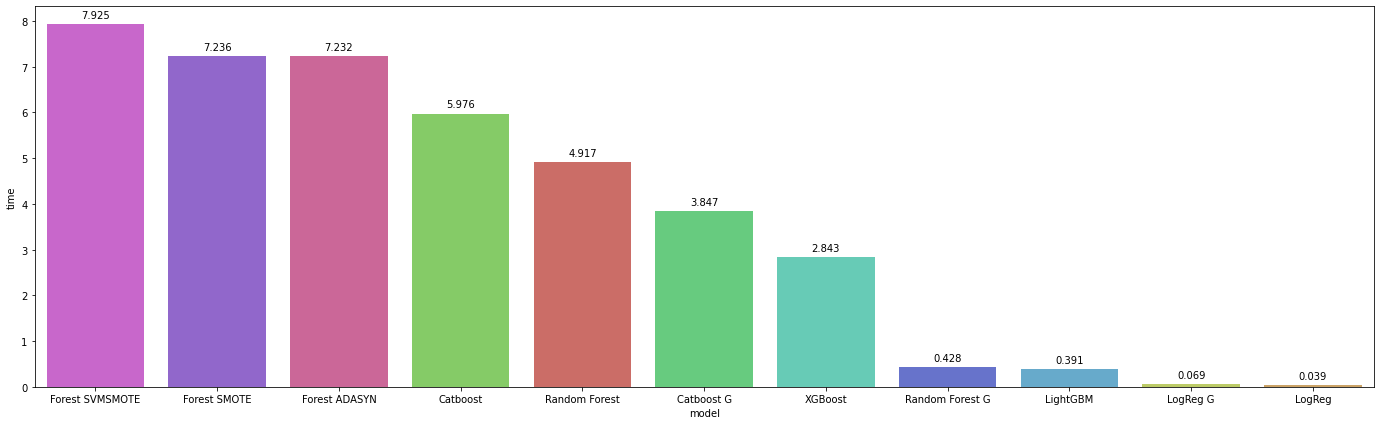

In [ ]:
build_analysis('time')

Видим, что лучше всего себя показывают Catboost (однако он и работает дольше остальных моделей), и случайный лес, при этом аугментации данных приводят к улушениям одних метрик, и ухудшениям других. В итоге, в качестве оптимальных на этом этапе моделей можно взять 


1.   Catboost бустинг
2.   Случайный лес с гиперпараметрами, перебранными на максимизацию прибыли



# Калибровка моделей

Так как для получения оценки прибыли мы используем вероятности, предсказанные моделью для нашей калибровки, встает вопрос, насколько эффективно выдача нашей модели оценивает реальную вероятность того, что человек вернет кредит. Построим calibration curve, чтобы оценить качество оценки вероятностей лучших моделей.

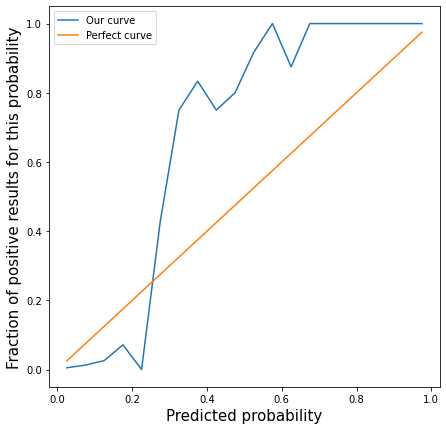

In [ ]:
build_calibration_curve(forest_f, X_test, y_test, sz=(7,7))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



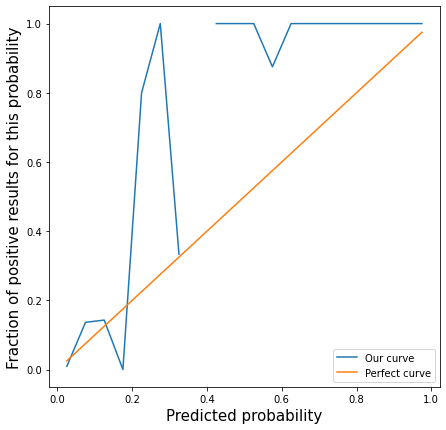

In [ ]:
build_calibration_curve(catboost, X_test, y_test, sz=(7,7))

Как видно, модели не очень хорошо передают настоящее распределение вероятностей. Такую "S-образную" форму кривой можно объяснить [$^1$](https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf) высокой вариативностью каждого из деревьев используемых в RandomForest, в результате чего получить среднее предзсказание деревьев ровно в 0 почти невозможно, так как тогда все деревья должны были бы выдать одно и то же нулевое предсказание, что маловероятно.

**Лес**

In [ ]:
cal_rfc = CalibratedClassifierCV(RandomForestClassifier(**study_forest_f.best_trial.params, random_state=179, n_jobs=-1))
run(cal_rfc, X_train, y_train, X_test, y_test, name='Forest Cal', x=15)
"done"

====== Forest Cal ======

Accuracy:	0.9664429530201343
Pos/neg ratio:	0.27350427350427353

Kappa coef:	0.901624191205599
Matthews coef:	0.9017987566570709
ROC-AUC value:	0.9903053523743179
PR-AUC value:	0.9763480673072642

Precision:	0.9375
Recall: 	0.9090909090909091
F-score:	0.923076923076923
Financial gain:	0.20446884126816567

Time elapsed: 0m 2s


'done'

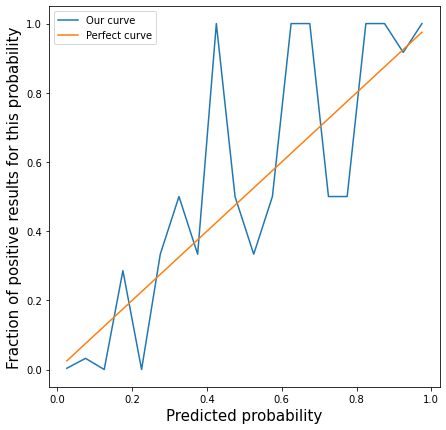

In [ ]:
build_calibration_curve(cal_rfc, X_test, y_test, sz=(7,7))

**Бустинг**

In [ ]:
cal_catboost = CalibratedClassifierCV(CatBoostClassifier(**study_catboost.best_trial.params, random_state=179, task_type="GPU"))
run(cal_catboost, X_train, y_train, X_test, y_test, name='Catboost Cal', x=15)
"done"

====== Catboost Cal ======

Accuracy:	0.9731543624161074
Pos/neg ratio:	0.2556179775280899

Kappa coef:	0.9198350071736012
Matthews coef:	0.9211514393136315
ROC-AUC value:	0.994339951236503
PR-AUC value:	0.9824515232385878

Precision:	0.978021978021978
Recall: 	0.898989898989899
F-score:	0.9368421052631579
Financial gain:	0.19669469955546173

Time elapsed: 0m 29s


'done'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



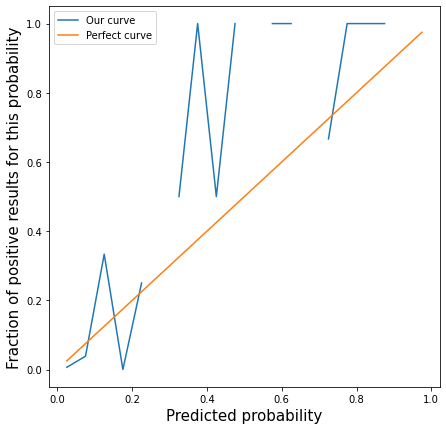

In [ ]:
build_calibration_curve(cal_catboost, X_test, y_test, sz=(7,7))

**Обновленные графики**

In [ ]:
# [ac, auc_pr, fscore, gains, elapsed, name]
names = list(logs.keys())

log_data = pd.DataFrame()
log_data['model'] = names
log_data['accuracy'] = [logs[nm][0] for nm in names]
log_data['auc_pr'] = [logs[nm][1] for nm in names]
log_data['fscore'] = [logs[nm][2] for nm in names]
log_data['gains'] = [logs[nm][3] for nm in names]
log_data['time'] = [logs[nm][4] for nm in names]

colors = np.array(sns.color_palette("hls", len(names)))

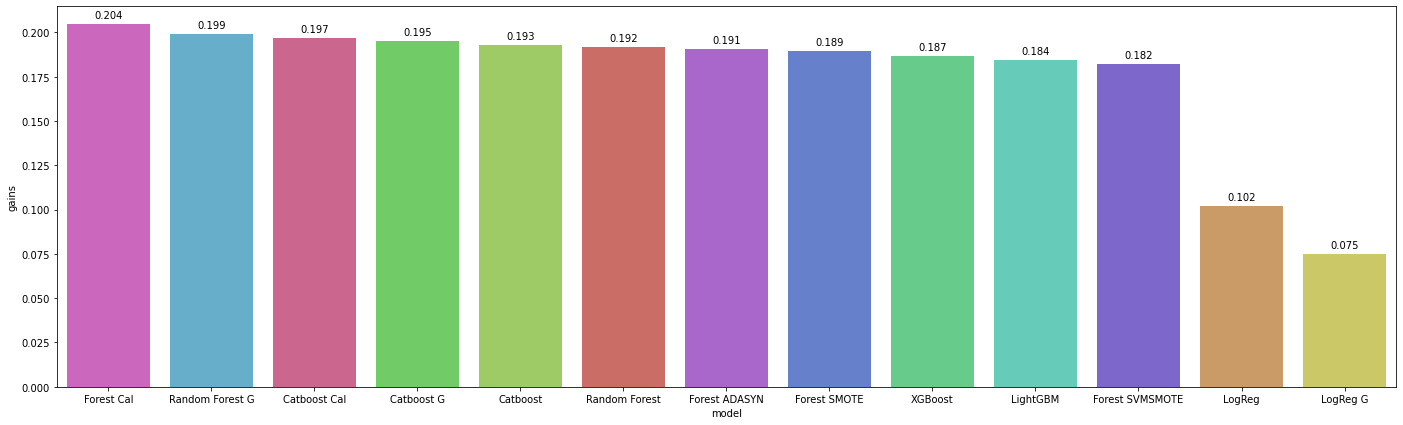

In [ ]:
build_analysis('gains')

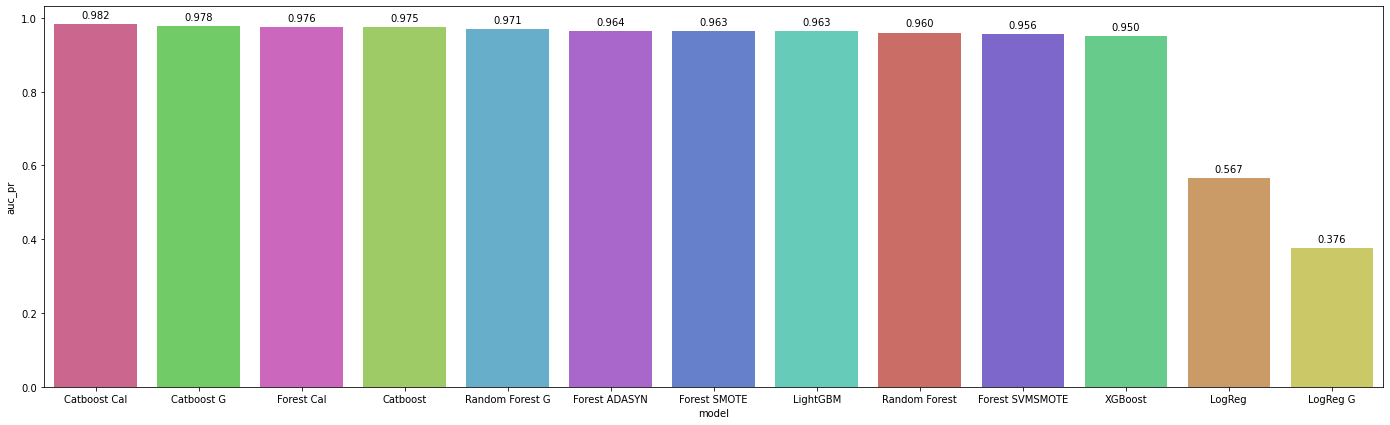

In [ ]:
build_analysis('auc_pr')

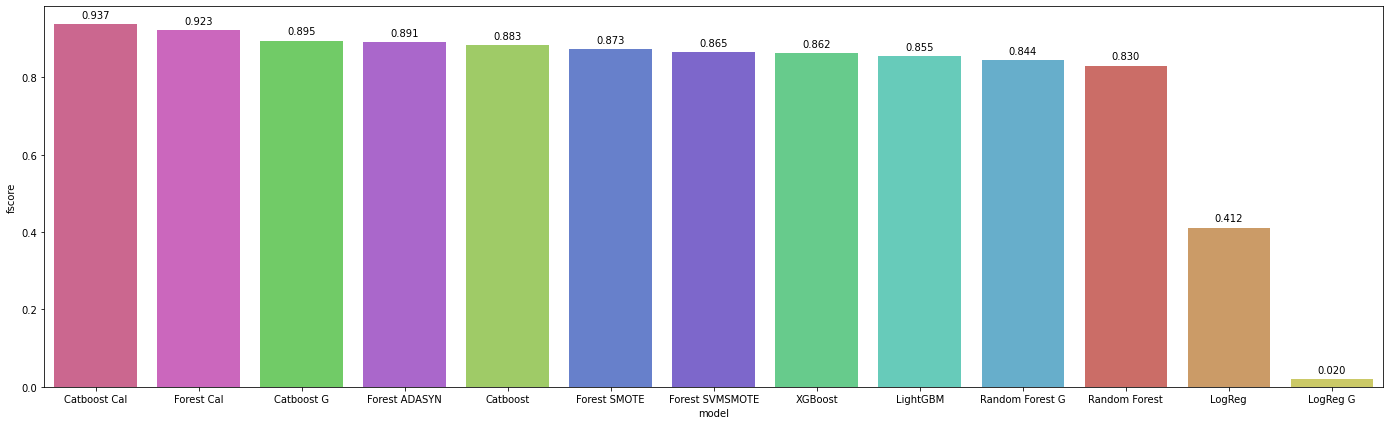

In [ ]:
build_analysis('fscore')

Калибровка улучшила результаты. В итоге можем установить, что
 

*   наиболее корректно решает задачу предсказания дефолта откалиброваннй градиентный бустинг Catboost
*   наибольшую прибыль приносит откалиброванный случайный лес

In [ ]:
best_model = cal_catboost

# Графический интерфейс

In [ ]:
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


In [ ]:
%%capture
! pip install anvil-uplink
import anvil.server
anvil.server.connect("TPTGFCHA6DFXBNKLUDNBWUM2-B3DCUKXS6BVDGXLO")

In [ ]:
@anvil.server.callable
def predict_client(LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC):
    client = pd.DataFrame()

    client['LOAN'] = [LOAN]
    client['MORTDUE'] = [MORTDUE]
    client['VALUE'] = [VALUE]
    client['REASON'] = [REASON]
    client['JOB'] = [JOB]
    client['YOJ'] = [YOJ]
    client['DEROG'] = [DEROG]
    client['DELINQ'] = [DELINQ]
    client['CLAGE'] = [CLAGE]
    client['NINQ'] = [NINQ]
    client['CLNO'] = [CLNO]
    client['DEBTINC'] = [DEBTINC]

    client = client.drop('DEBTINC', axis=1)
    client[['JOB', 'REASON']] = client[['JOB', 'REASON']].fillna('NAN')

    client = client.fillna(df_pure.mean(axis=0))
    X = client.values

    X = np.concatenate((X[:, :3], ohe.transform(X[:, [3, 4]]), X[:, 5:]), axis=1)

    return best_model.predict(X)[0], 1 - best_model.predict_proba(X)[0][1]

In [ ]:
ohe.categories_

[array(['DebtCon', 'HomeImp', 'NAN'], dtype=object),
 array(['Mgr', 'NAN', 'Office', 'Other', 'ProfExe', 'Sales', 'Self'],
       dtype=object)]

In [ ]:
def pupa(LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC):
    client = pd.DataFrame()

    client['LOAN'] = [int(LOAN)]
    client['MORTDUE'] = [int(MORTDUE)]
    client['VALUE'] = [int(VALUE)]
    client['REASON'] = [REASON]
    client['JOB'] = [JOB]
    client['YOJ'] = [float(YOJ)]
    client['DEROG'] = [int(DEROG)]
    client['DELINQ'] = [int(DELINQ)]
    client['CLAGE'] = [float(CLAGE)]
    client['NINQ'] = [int(NINQ)]
    client['CLNO'] = [int(CLNO)]
    client['DEBTINC'] = [float(DEBTINC)]

    client = client.drop('DEBTINC', axis=1)
    client[['JOB', 'REASON']] = client[['JOB', 'REASON']].fillna('NAN')

    client = client.fillna(df_pure.mean(axis=0))
    X = client.values
    print(client)
    X = np.concatenate((X[:, :3], ohe.transform(X[:, [3, 4]]), X[:, 5:]), axis=1)

    return best_model.predict(X)[0], 1 - best_model.predict_proba(X)[0][1]

pupa(100, 100, 100, "HomeImp", "Other", 100, 100, 100, 100, 100, 100, 100)

   LOAN  MORTDUE  VALUE   REASON    JOB  ...  DEROG  DELINQ  CLAGE  NINQ  CLNO
0   100      100    100  HomeImp  Other  ...    100     100  100.0   100   100

[1 rows x 11 columns]


(1, 0.8518518518518519)